In [2]:
import numpy as np
import os
import cv2
import math

import matplotlib.pyplot as plt

In [3]:
source_path = os.path.join('data', 'ara.png')
source = cv2.imread(source_path)
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)

<Axes: title={'center': 'Исходник'}>

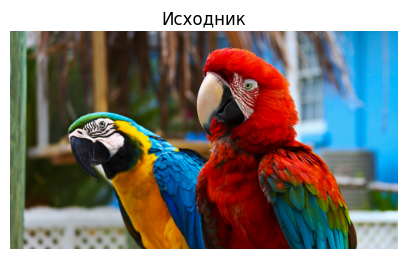

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 7)
ax.imshow(source)
ax.set_title('Исходник')
ax.set_axis_off()
ax

In [5]:
print(f'image size is {source.shape}, image weight is {source.nbytes} bytes')

image size is (554, 987, 3), image weight is 1640394 bytes


In [6]:
source[0, 0, :]

array([ 84, 108,  80], dtype=uint8)

### шаг 1: конвертация цветового пространства | step 1: color space convertation

In [7]:
def RGB2YCrCb(source:np.ndarray)->np.ndarray:
    '''
    переводит изображение из формата RGB в формат YCrCb
    transforms RGB to YCrCb format
    '''
    matrix = np.array([
        [0.299, 0.587, 0.114],
        [0.5, -0.4187, -0.0813],
        [0.1687, -0.3313, 0.5]
    ])
    bias = np.array([0, 128, 128])

    dst = source@matrix + bias
    dst -= dst.min()
    dst /= dst.max()
    dst*=255.
    # print(dst.min())
    # print(dst.max())
    
    return dst.astype(np.uint8)

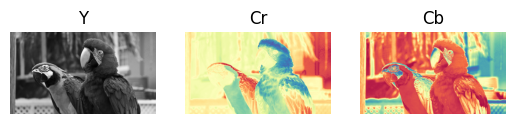

In [36]:
YCrCb = RGB2YCrCb(source)
fig, ax = plt.subplots(1, 3)
titles = ['Y', 'Cr', 'Cb']
cmaps = ['gray', 'Spectral', 'Spectral']
for i in range(3):
    ax[i].imshow(YCrCb[:, :, i], cmap = cmaps[i])
    ax[i].set_title(titles[i])
    ax[i].set_axis_off()
    

### шаг 2: понижение размерности цветовых каналов | step 2: downsapling color channels

In [9]:
def make_multiple_of_16(source:np.ndarray)->np.ndarray:
    '''
    приводит изображение к размерности, кратной 16, для упрощения в учебных целях
    transform image to multiple-of-16 dimension for simplify in study goals
    '''
    h, w = source.shape[:2]
    multiplier_h = math.ceil(h/16)
    multiplier_w = math.ceil(w/16)
    return cv2.resize(source.copy(), (multiplier_w*16, multiplier_h*16))
    
def get_every_second(source:np.ndarray)->np.ndarray:
    '''
    берет каждое второе значение по двум размерностям
    get every second value from two dimensions
    '''
    compressed = source[::2, ::2].copy()
    return compressed

YCrCb = make_multiple_of_16(YCrCb)
Cr_compressed = get_every_second(YCrCb[:, :, 1])
Cb_compressed = get_every_second(YCrCb[:, :, 2])
Cr_compressed.shape


(280, 496)

In [10]:
def restore_img(compressed:np.ndarray, shape:tuple[int, int])->np.ndarray:
    '''
    восстанавливает изображения из пониженной размерности шага 2
    restores image from compressed one from step 2
    '''
    restored = np.repeat(compressed, 2, axis = 0).copy()
    restored = np.repeat(restored, 2, axis = 1)
    return restored[:shape[0], :shape[1]]
Cr_restored = restore_img(Cr_compressed, YCrCb[:, :, 0].shape)
Cb_restored = restore_img(Cb_compressed, YCrCb[:, :, 0].shape)
Cb_restored.shape

(560, 992)

In [11]:
YCrCb_restored = np.stack((YCrCb[:, :, 0].copy(),  Cr_restored, Cb_restored), axis = -1)
YCrCb_restored.shape

(560, 992, 3)

In [12]:
print(f'images weight relation already is {(YCrCb[:, :, 0].copy().nbytes+Cr_compressed.nbytes+Cb_compressed.nbytes)/source.nbytes}')

images weight relation already is 0.5079755229536319


In [13]:
Cr_restored = np.repeat(Cr_compressed, 2, axis =0)
Cr_restored = np.repeat(Cr_restored, 2, axis = 1)
Cr_restored[:, :]

array([[119, 119, 115, ...,  29,  31,  31],
       [119, 119, 115, ...,  29,  31,  31],
       [120, 120, 116, ...,  29,  34,  34],
       ...,
       [130, 130, 128, ..., 101, 101, 101],
       [130, 130, 128, ..., 103, 102, 102],
       [130, 130, 128, ..., 103, 102, 102]], shape=(560, 992), dtype=uint8)

### шаг 3: ДКП | step 3: DCT

D = C@S@C.T

S = C.T@D@C

In [15]:
N = 8
def get_dct_II_matrix(N:int):
    """базис дискретного косинусного преобразования 2-го типа"""
    dct = np.zeros((N, N))
    for n in range(N):
        dct[0][n] = math.sqrt(1/N)
    for m in range(1, N):
        for n in range(N):
            dct[m][n]=math.sqrt(2/N)*math.cos((2*n+1)*math.pi*m/(2*N))
    return dct

dct = get_dct_II_matrix(N)

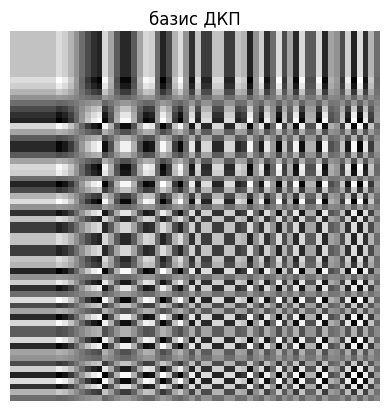

In [17]:
def get_base_image(N:int)->np.ndarray:
    '''
    возвращает изображение базиса ДКП для NxN точек
    returns basis DCT images
    '''
    dct = get_dct_II_matrix(N)
    base=np.zeros((N*N,N*N))
    for i in range(N):
        for j in range(N):
            pos_m=i*N
            pos_n=j*N
            DCT_v=dct[i,:].reshape(-1,1)
            DCT_T_h=dct.T[:,j].reshape(-1,N)
            base[pos_m:pos_m+N,pos_n:pos_n+N]=DCT_v@DCT_T_h
    base+=np.absolute(base.min())
    scale=np.around(1/base.max(),decimals=3)
    for i in range(base.shape[0]):
        for j in range(base.shape[1]):
            base[i][j]=np.around(base[i][j]*scale,decimals=3)
    return base

base = get_base_image(N)
plt.axis('off')
plt.title('базис ДКП')
plt.imshow(base, cmap = 'gray', vmin = 0)

In [19]:
def build_snake_matrix(size:int):
    '''build example matrix'''
    steps = 2*size-1
    matrix = [[0]*size for _ in range(size)]
    number = 0
    for k in range(steps):
        if k%2==1:
            j = min(k, size-1)
            i = k-j
            while j>=0 and i<size:
                matrix[i][j] = number
                number+=1
                j-=1
                i+=1
        else:
            i = min(k, size-1)
            j = k-i
            while i>=0 and j<size:
                matrix[i][j] = number
                number+=1
                j+=1
                i-=1
    return np.array(matrix)
            

def get_snake_mask(count:int, size:int)->list:
    '''get elements in `snake` order'''
    if count>=size**2: return np.ones((size, size))
    mask = np.zeros((size, size))
    i, j = 0, 0
    for k in range(count):
        if k==0: 
            mask[i][j] = 1
        else:
            if (i+j)%2==0:
                i = max(i-1, 0)
                j = min(j+1, size-1)
            else:
                i = min(i+1, size-1)
                j = max(j-1, 0)
            mask[i][j] = 1
    return mask
            
snake = build_snake_matrix(N)
print(snake)
mask = get_snake_mask(15, N)
print(snake*mask)

[[ 0  1  5  6 14 15 27 28]
 [ 2  4  7 13 16 26 29 42]
 [ 3  8 12 17 25 30 41 43]
 [ 9 11 18 24 31 40 44 53]
 [10 19 23 32 39 45 52 54]
 [20 22 33 38 46 51 55 60]
 [21 34 37 47 50 56 59 61]
 [35 36 48 49 57 58 62 63]]
[[ 0.  1.  5.  6. 14.  0.  0.  0.]
 [ 2.  4.  7. 13.  0.  0.  0.  0.]
 [ 3.  8. 12.  0.  0.  0.  0.  0.]
 [ 9. 11.  0.  0.  0.  0.  0.  0.]
 [10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


Text(0.5, 1.0, 'первые 3')

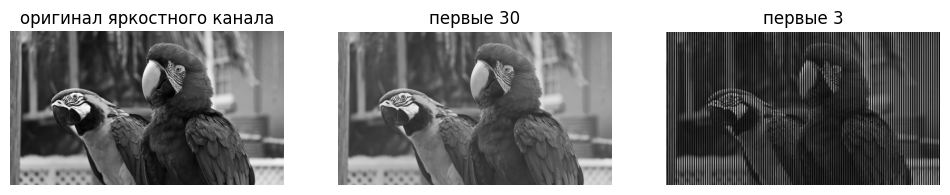

In [41]:
def compress(img, mask, N):
    '''сжатие изображения за счёт выбора более информативных измерений'''
    C = get_dct_II_matrix(N)
    img_compressed = np.zeros((img.shape[0]//N*N, img.shape[1]//N*N))
    for i in range(0, img_compressed.shape[0], N):
        for j in range(0, img_compressed.shape[1], N):
            block=img[i:i+N,j:j+N].copy()
            # DCT            
            coeff=C@block@(C.T)
            block = coeff*mask
            img_compressed[i:i+N,j:j+N]=block
    return img_compressed

def dct2rgb(img_compressed, N):
    C = get_dct_II_matrix(N)
    YCrCb = np.zeros((img_compressed.shape[0]//N*N, img_compressed.shape[1]//N*N))
    for i in range(0, img_compressed.shape[0], N):
        for j in range(0, img_compressed.shape[1], N):
            block = img_compressed[i:i+N,j:j+N].copy()
            y_block=(C.T)@block@C
            YCrCb[i:i+N,j:j+N]=y_block
    return YCrCb

# snake_mask_3 = get_snake_mask(3, N)
# compressed_Y_3 = compress(YCrCb[:, :, 0], snake_mask_3, N)
# decompressed_Y_3 = dct2rgb(compressed_Y_3, N)
# # print(decompressed_Y_3.shape)
snake_mask_30 = get_snake_mask(30, N)
compressed_Y_30 = compress(YCrCb[:, :, 0], snake_mask_30, N)
decompressed_Y_30 = dct2rgb(compressed_Y_30, N)


fig, ax = plt.subplots(1, 3)
fig.set_size_inches((12, 4))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].imshow(YCrCb[:, :, 0], cmap = 'gray')
ax[1].imshow(decompressed_Y_30, cmap = 'gray', vmin = 0)
ax[2].imshow(decompressed_Y_3, cmap = 'gray', vmin = 0)
ax[0].set_title('оригинал яркостного канала')
ax[1].set_title('первые 30')
ax[2].set_title('первые 3')

In [114]:
def reshape2lines(img_compressed:np.ndarray)->np.ndarray:
    blocks = []
    for i in range(0, img_compressed.shape[0], N):
        for j in range(0, img_compressed.shape[1], N):
            block = img_compressed[i:i+N,j:j+N].copy()
            blocks.append(block)
    return np.array(blocks)
reshaped = reshape2lines(compressed_Y_30)
print(reshaped.shape)
print(reshaped[0])
# reshaped = compressed_Y_30
# reshaped[:N, :N]
print(compressed_Y_30.shape)
reshaped = compressed_Y_30.reshape((-1, N, compressed_Y_30.shape[1]), order = 'C') # (69, 8, 123*8)
reshaped = reshaped.reshape((-1, N, compressed_Y_30.shape[1]//N, N), order = 'C') # (69, 8, 123, 8)
reshaped = np.moveaxis(reshaped, 1, 2).reshape((-1, N, N)) # (69, 123, 8, 8) -> (8487, 8, 8)
reshaped[0]
# print(reshaped[0, :, 0, :])

(8487, 8, 8)
[[ 9.64875000e+02  9.82564179e-01 -3.41447394e+01 -4.00195992e+00
  -4.37500000e+00  2.55319455e-01  2.07414567e-01  5.15942276e-01]
 [-2.23919925e+00 -4.89930510e+00 -7.06489770e+00 -1.07185092e+00
   1.89563765e-01 -4.35244094e-01 -5.88737745e-03  0.00000000e+00]
 [-1.46988334e+00 -8.41531902e-01 -2.04549513e+00  1.05276233e-01
   1.74048139e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [-1.12262911e-01 -1.10118006e+00 -3.78477661e-01 -4.71244125e-01
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.12500000e+00 -3.66295517e-01 -5.29589279e-01 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.27005652e-01 -3.29274211e-01 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [-6.08845613e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.000

array([[ 9.64875000e+02,  9.82564179e-01, -3.41447394e+01,
        -4.00195992e+00, -4.37500000e+00,  2.55319455e-01,
         2.07414567e-01,  5.15942276e-01],
       [-2.23919925e+00, -4.89930510e+00, -7.06489770e+00,
        -1.07185092e+00,  1.89563765e-01, -4.35244094e-01,
        -5.88737745e-03,  0.00000000e+00],
       [-1.46988334e+00, -8.41531902e-01, -2.04549513e+00,
         1.05276233e-01,  1.74048139e+00, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00],
       [-1.12262911e-01, -1.10118006e+00, -3.78477661e-01,
        -4.71244125e-01, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.12500000e+00, -3.66295517e-01, -5.29589279e-01,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 8.27005652e-01, -3.29274211e-01, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00],
       [-6.08845613e-01, -0.000000